- Defines output directory (exp3/)
- Sets model ID, precision (fp16), number of diffusion steps (N_STEPS), transformer levels (N_LEVELS), and random seed.
- Loads the SANA model with weights from the Hugging Face repo.
- Pushes the model and VAE/text encoder to GPU with the right precision.

In [1]:
# ==============================================================
#  imports, global config, and pipeline load
#  ─────────────────────────────────────────────────────────────
#  • Sets basic experiment parameters (model id, #steps…)
#  • Loads the SANA pipeline on GPU, casting weights to fp16/bf16
# ==============================================================
import math, itertools, pathlib
import torch, tqdm 
from diffusers import SanaPipeline
import re, matplotlib.pyplot as plt
from PIL import Image

In [2]:
# ---------- directory where all outputs will be saved ----------
OUTDIR = pathlib.Path("exp3")             # folder name
OUTDIR.mkdir(exist_ok=True)                  # create if it doesn't exist

# ---------- experiment hyper‑parameters -----------------------
MODEL_ID   = "Efficient-Large-Model/Sana_1600M_1024px_diffusers"
DTYPE      = torch.float16                   # weights dtype for GPU
DEVICE     = "cuda"                          # or "mps" / "cpu" if needed
N_STEPS    = 20                              # diffusion steps  (T)
N_LEVELS   = 20                              # transformer blocks (L)
SEED       = 42                              # reproducible randomness
PROMPT_TXT = "sana_position_prompts.txt"         # text file – one prompt / line


# ---------- load SANA pipeline --------------------------------
pipe = (
    SanaPipeline           # diffusers class
    .from_pretrained(MODEL_ID, variant="fp16", torch_dtype=DTYPE)
    .to(DEVICE)            # push entire pipeline to GPU
)

pipe.vae         .to(torch.bfloat16)
pipe.text_encoder.to(torch.bfloat16)
pipe.scheduler.set_timesteps(N_STEPS)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

This part prepares tools for running and tracking experiments:
- Tracks which timestep (t) the model is currently processing via a forward_pre_hook.
- Loads text prompts from the file sana_position_prompts.txt.
- Defines a generate() helper function to run the pipeline and save results to disk.

In [3]:
# ==============================================================
#  utility hooks / helpers
#  ─────────────────────────────────────────────────────────────
#  • step_counter: lets us know which diffusion step (t) we’re on
#  • PROMPTS: list of prompts loaded from the text file
#  • generate(): helper to run the pipeline and save an image
# ==============================================================
# -------- 1. step counter (pre‑hook on entire transformer) ----
step_counter = {"t": -1}                     # wrapped in dict for mutability

def _count_steps(_, __):
    """Executed *before* each denoising step; increments global t."""
    step_counter["t"] += 1

pipe.transformer.register_forward_pre_hook(_count_steps)

# -------- 2. load prompts -------------------------------------
with open(PROMPT_TXT) as f:
    PROMPTS = [ln.strip() for ln in f if ln.strip()]
print("Loaded", len(PROMPTS), "prompts")

# -------- 3. generate & save helper ---------------------------
def generate(prompt: str,
             seed: int,
             filename: str,
             ):
    """
    Runs the pipeline once and writes PNG → OUTDIR/filename
    If hooks_enabled=False the model runs normally; otherwise
    already‑registered hooks (mean or swap) will manipulate outputs.
    """
    step_counter["t"] = -1                   # reset timestep counter

    # Deterministic generator for reproducibility
    gen = torch.Generator(device=DEVICE).manual_seed(seed)

    # Run diffusion
    img = pipe(
        prompt,
        height=1024, width=1024,
        num_inference_steps=N_STEPS,
        guidance_scale=5.0,                 # classifier‑free guidance weight
        generator=gen
    )[0][0]                                    # diffusers returns (images, …)
    img.save(OUTDIR / filename)
    return img                              # return PIL.Image for display


Loaded 453 prompts


# Phase A – Mean Activation Collection
- This phase records the average output of every FFN block at every timestep across all prompts.
- Hooks are registered to all FFN modules.
- For each prompt, we run the pipeline and record FFN outputs.
- After all prompts, the average activation per layer and timestep is computed.
- Final means are saved as ffn_mean_maps.pt.--> exp3/ffn_mean_maps.pt

In [4]:
# =============================================================
#  Phase A -- load or build ⟨level, t⟩ mean maps
# =============================================================
import torch, os, tqdm

ffn_mean_path = OUTDIR / "ffn_mean_maps.pt"

# -------------------------------------------------------------
# 0)  Fast path: reuse pre-computed mean maps
# -------------------------------------------------------------
if ffn_mean_path.exists():
    means = torch.load(ffn_mean_path, map_location="cpu")
    print(f"[✓] Reusing cached mean maps from {ffn_mean_path}")
else:
    print("[…] No cached mean maps found – collecting them now.")
    
    # ---------- 1. storage containers -------------------------
    means = [[None] * N_STEPS for _ in range(N_LEVELS)]
    n_prompts_seen = 0

    def make_record_hook(level: int):
        def _hook(_, __, out):
            t = step_counter["t"]
            if t >= N_STEPS:                      # skip extra final call
                return out
            avg_tokens = out.detach().float().mean(0)      # (seq, hidden)
            means[level][t] = (
                avg_tokens if means[level][t] is None
                else means[level][t] + avg_tokens
            )
            return out
        return _hook

    H_REC = [
        blk.ff.register_forward_hook(make_record_hook(lvl))
        for lvl, blk in enumerate(pipe.transformer.transformer_blocks)
    ]

    # ---------- 3. run pipeline over all prompts --------------
    for prompt in tqdm.tqdm(PROMPTS, desc="Collect means"):
        step_counter["t"] = -1
        _ = pipe(
            prompt,
            height=1024, width=1024,
            num_inference_steps=N_STEPS,
            guidance_scale=5.0,
            generator=torch.Generator(device=DEVICE).manual_seed(SEED + n_prompts_seen),
        )
        n_prompts_seen += 1

    # ---------- 4. finalise & save ----------------------------
    for h in H_REC: h.remove()
    means = [[m / n_prompts_seen for m in row] for row in means]
    torch.save(means, ffn_mean_path)
    print(f"[✓] Mean maps saved → {ffn_mean_path}")


/tmp/ipykernel_487605/828734276.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means = torch.load(ffn_mean_path, map_location="cpu")


[✓] Reusing cached mean maps from exp3/ffn_mean_maps.pt


# Phase B – Mean Activation Ablation
This phase tests how each layer behaves when its activations are replaced with the mean from Phase A.
- Registers new hooks that overwrite each FFN's output with its mean at time t.
- Generates baseline and mean-ablated images for the first 5 prompts
- Saves both versions for visual comparison.
- Displays side-by-side comparison using matplotlib.
Output Directory: exp3/results/

In [7]:
# ==============================================================
#  PHASE B – baselines first, then mean‑ablation, then clean‑up
# ==============================================================

N_PROMPTS_B = 5
for i in range(N_PROMPTS_B):
    print(f"prompt: {PROMPTS[i]}")

RESULTS_DIR = OUTDIR / "results"; RESULTS_DIR.mkdir(exist_ok=True)

def _slug(s, n=35):
    s = re.sub(r"[^\w\s-]", "", s).strip().lower()
    return re.sub(r"[\s_-]+", "_", s)[:n]

# ---------------- Baselines -----------------------------------
baseline_files = []
for i, prompt in enumerate(tqdm.tqdm(PROMPTS[:N_PROMPTS_B], desc="Phase B – baselines")):
    fname = f"baseline_{i:02d}_{_slug(prompt)}.png"
    generate(prompt, SEED + i, fname)
    (OUTDIR / fname).replace(RESULTS_DIR / fname)
    baseline_files.append((RESULTS_DIR / fname).resolve())

print("\n[Phase B] Baseline images:")
for p in baseline_files:
    print("  •", p)

# ---------------- Mean‑ablation hooks -------------------------
def make_mean_hook(level):
    def _hook(_, __, out):
        t = step_counter["t"]
        if t < N_STEPS:
            m = means[level][t].to(out.device).to(out.dtype)
            return m.unsqueeze(0).expand_as(out)
        return out
    return _hook

H_MEAN = [blk.ff.register_forward_hook(make_mean_hook(lvl))
          for lvl, blk in enumerate(pipe.transformer.transformer_blocks)]

# ---------------- Ablated images ------------------------------
mean_files = []
for i, prompt in enumerate(tqdm.tqdm(PROMPTS[:N_PROMPTS_B], desc="Phase B – mean ablate")):
    fname = f"mean_{i:02d}_{_slug(prompt)}.png"
    #generate(prompt, SEED + i, fname)
    generate(prompt, SEED, fname)
    (OUTDIR / fname).replace(RESULTS_DIR / fname)
    mean_files.append((RESULTS_DIR / fname).resolve())

print("\n[Phase B] Mean‑ablation images:")
for p in mean_files:
    print("  •", p)

# detach hooks
for h in H_MEAN: h.remove()
H_MEAN.clear()



prompt: a banana at the top of the image and an apple at the bottom.
prompt: a balloon at the top, house in the bootom and sky in the right.
prompt: a cyberpunk cat with a neon sign that says "Sana"
prompt: a chair on the left side.
prompt: a lamp in the top‑left corner, a dog in the top‑right corner, a balloon in the bottom‑left corner, and a boat in the bottom‑right corner.


Phase B – baselines:   0%|                                                    | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – baselines:  20%|████████▊                                   | 1/5 [00:03<00:14,  3.59s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – baselines:  40%|█████████████████▌                          | 2/5 [00:07<00:10,  3.62s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – baselines:  60%|██████████████████████████▍                 | 3/5 [00:10<00:07,  3.61s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – baselines:  80%|███████████████████████████████████▏        | 4/5 [00:14<00:03,  3.65s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – baselines: 100%|████████████████████████████████████████████| 5/5 [00:18<00:00,  3.65s/it]



[Phase B] Baseline images:
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_00_a_banana_at_the_top_of_the_image_an.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_01_a_balloon_at_the_top_house_in_the_b.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_02_a_cyberpunk_cat_with_a_neon_sign_th.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_03_a_chair_on_the_left_side.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_04_a_lamp_in_the_topleft_corner_a_dog_.png


Phase B – mean ablate:   0%|                                                  | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – mean ablate:  20%|████████▍                                 | 1/5 [00:05<00:20,  5.06s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – mean ablate:  40%|████████████████▊                         | 2/5 [00:09<00:14,  4.87s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – mean ablate:  60%|█████████████████████████▏                | 3/5 [00:14<00:09,  4.84s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – mean ablate:  80%|█████████████████████████████████▌        | 4/5 [00:19<00:04,  4.83s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase B – mean ablate: 100%|██████████████████████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


[Phase B] Mean‑ablation images:
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/mean_00_a_banana_at_the_top_of_the_image_an.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/mean_01_a_balloon_at_the_top_house_in_the_b.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/mean_02_a_cyberpunk_cat_with_a_neon_sign_th.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/mean_03_a_chair_on_the_left_side.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/mean_04_a_lamp_in_the_topleft_corner_a_dog_.png


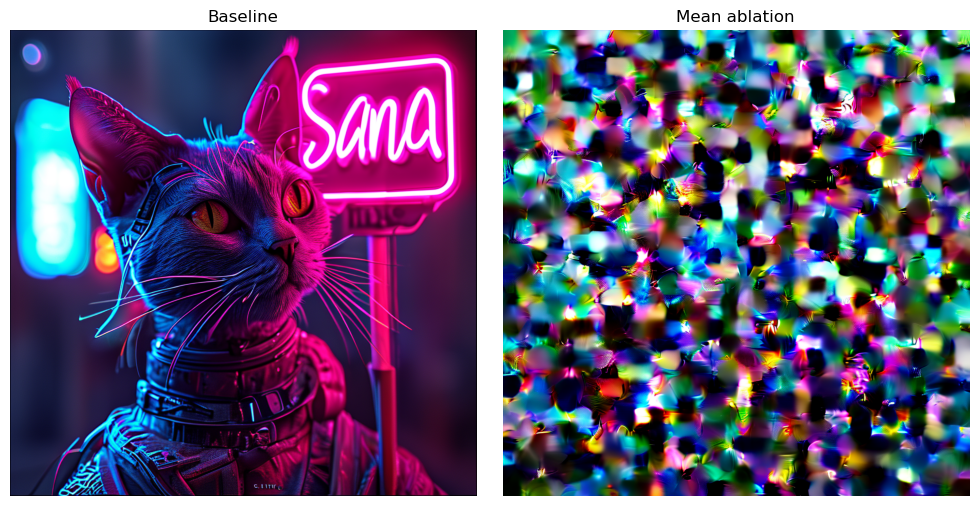

In [10]:

# --------------- Preview first pair -------------------
idx = 2
b0 = Image.open(RESULTS_DIR / f"baseline_{idx:02d}_{_slug(PROMPTS[idx])}.png")
m0 = Image.open(RESULTS_DIR / f"mean_{idx:02d}_{_slug(PROMPTS[idx])}.png")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(b0); ax[0].set_title("Baseline");      ax[0].axis("off")
ax[1].imshow(m0); ax[1].set_title("Mean ablation"); ax[1].axis("off")
plt.tight_layout(); plt.show()

# Phase C – Left↔Right Swap
Here, the mean maps are spatially manipulated by swapping left and right halves, simulating altered visual attention.
- Previous mean hooks are removed.
- New swap maps are created (L×T spatial tensors with left-right halves flipped).
- Hooks overwrite the FFN outputs with these swapped maps.
- Two images are generated for a single test prompt: baseline vs. swapped.
- Shows the side-by-side result.
Output Directory: exp3/results/

In [11]:
# ==============================================================
#  PHASE C – Left ↔ Right swap for a batch of prompts
# ==============================================================

import re, tqdm, matplotlib.pyplot as plt
from PIL import Image
import torch, gc

# --------‑ user controls --------------------------------------
N_PROMPTS_C   = 5                 # how many prompts to process
RESULTS_DIR   = OUTDIR / "results"; RESULTS_DIR.mkdir(exist_ok=True)

def _slug(s, n=40):
    s = re.sub(r"[^\w\s-]", "", s).strip().lower()
    return re.sub(r"[\s_-]+", "_", s)[:n]

# --------‑ 0. make sure model is hook‑free --------------------
for lst in ("H_MEAN", "H_SWAP"):
    if lst in globals():
        for h in globals()[lst]:
            h.remove()
        globals()[lst].clear()

# --------‑ 1. pre‑compute left↔right‑swapped mean maps --------
swap_maps = []
for level_row in means:        # over transformer levels
    new_row = []
    for m in level_row:        # m : (C,H,W)
        C, H, W = m.shape; split = W // 2
        s = m.clone()
        s[:, :, :split], s[:, :, split:] = s[:, :, split:], s[:, :, :split]
        new_row.append(s)
    swap_maps.append(new_row)

# --------‑ 2. hook helpers ------------------------------------
H_SWAP = []
def make_swap_hook(level):
    def _hook(_, __, out):
        t = step_counter["t"]
        if t < N_STEPS:
            m = swap_maps[level][t].to(out.device).to(out.dtype)
            return m.unsqueeze(0).expand_as(out)
        return out
    return _hook

def attach_swap_hooks():
    global H_SWAP
    H_SWAP = [
        blk.ff.register_forward_hook(make_swap_hook(lvl))
        for lvl, blk in enumerate(pipe.transformer.transformer_blocks)
    ]

def detach_swap_hooks():
    for h in H_SWAP: h.remove()
    H_SWAP.clear()

# --------‑ 3. run over prompts -------------------------------
saved_files = []

for i, prompt in enumerate(tqdm.tqdm(PROMPTS[:N_PROMPTS_C], desc="Phase C")):
    base_png = f"baseline_swap_{i:02d}_{_slug(prompt)}.png"
    var_png  = f"swap_ablate_{i:02d}_{_slug(prompt)}.png"

    # baseline
    detach_swap_hooks()
    generate(prompt, SEED + i, base_png)
    (OUTDIR / base_png).replace(RESULTS_DIR / base_png)
    saved_files.append((RESULTS_DIR / base_png).resolve())

    # variant
    attach_swap_hooks()
    generate(prompt, SEED + i, var_png)
    (OUTDIR / var_png).replace(RESULTS_DIR / var_png)
    saved_files.append((RESULTS_DIR / var_png).resolve())
    detach_swap_hooks()

    gc.collect(); torch.cuda.empty_cache()

print(f"\n[Phase C] Saved {len(saved_files)} images:")
for p in saved_files:
    print("  •", p)
    



Phase C:   0%|                                                                | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase C:  20%|███████████▏                                            | 1/5 [00:08<00:34,  8.55s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase C:  40%|██████████████████████▍                                 | 2/5 [00:17<00:25,  8.57s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase C:  60%|█████████████████████████████████▌                      | 3/5 [00:25<00:17,  8.58s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase C:  80%|████████████████████████████████████████████▊           | 4/5 [00:34<00:08,  8.64s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase C: 100%|████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


[Phase C] Saved 10 images:
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_swap_00_a_banana_at_the_top_of_the_image_and_an_.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/swap_ablate_00_a_banana_at_the_top_of_the_image_and_an_.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_swap_01_a_balloon_at_the_top_house_in_the_bootom.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/swap_ablate_01_a_balloon_at_the_top_house_in_the_bootom.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_swap_02_a_cyberpunk_cat_with_a_neon_sign_that_sa.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/swap_ablate_02_a_cyberpunk_cat_with_a_neon_sign_that_sa.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_swap_03_a_chair_on_the_left_side.png
  • /home/chenpery/workspace/transf

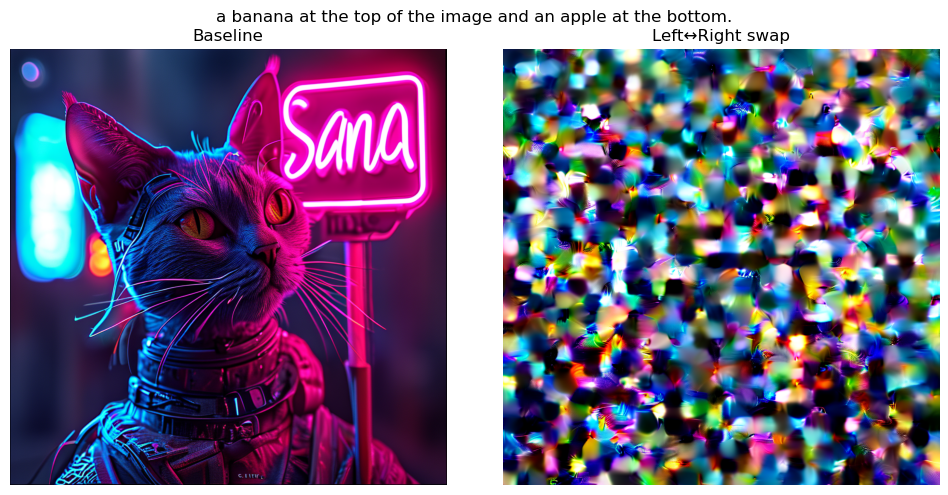

In [12]:
# --------‑ 4. preview first pair ------------------------------
idx = 2
img_b = Image.open(RESULTS_DIR / f"baseline_swap_{idx:02d}_{_slug(PROMPTS[idx])}.png")
img_v = Image.open(RESULTS_DIR / f"swap_ablate_{idx:02d}_{_slug(PROMPTS[idx])}.png")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_b); ax[0].set_title("Baseline");        ax[0].axis("off")
ax[1].imshow(img_v); ax[1].set_title("Left↔Right swap"); ax[1].axis("off")
fig.suptitle(PROMPTS[0], wrap=True); plt.tight_layout(); plt.show()

# Phase D –Spatial Transforms (FFN vs Attention)
This phase applies spatial modifications to the outputs of transformer components—FFN, self-attention (attn1), 
and cross-attention (attn2)—to analyze how they affect image structure and object positioning.
- "swap_tb": swap top and bottom halves
- "swap_lr": swap left and right halves
- "shuffle": randomly permute spatial tokens
- "first_token", "first_row", "first_col": replicate parts of the activation map
Output directory: exp3/results/

In [13]:
# ==============================================================
#  PHASE D – Live output transforms (unified version)
# ==============================================================

import re, math, tqdm, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch, gc

# ---------- user controls -------------------------------------
hook_target      = "attn2"          # "ffn" | "attn1" | "attn2"
transform_choice = "swap_tb"      # see list below
n_tokens         = 3              # only for "first_n_tokens"
rng_seed_base    = 777            # only for "shuffle"
N_PROMPTS_D      = 5              # how many prompts to run

# ---------- basic paths ---------------------------------------
RESULTS_DIR = OUTDIR / "results"; RESULTS_DIR.mkdir(exist_ok=True)

def _slug(s, n=40):
    s = re.sub(r"[^\w\s-]", "", s).strip().lower()
    return re.sub(r"[\s_-]+", "_", s)[:n]

# ---------- make sure no stale hooks remain -------------------
for lst in ("H_SWAP", "H_MEAN"):
    if lst in globals():
        for h in globals()[lst]:
            h.remove()
        globals()[lst].clear()

# ---------- shared transform helper ---------------------------
def apply_transform(x, *, H, W, level, t, g_seed):
    """
    x is (B, C, H, W) – returns same shape
    """
    if transform_choice == "first_token":
        tok = x[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)
        return tok

    elif transform_choice == "first_n_tokens":
        coords = [(r, c) for r in range(H) for c in range(W)][:n_tokens]
        mean_tok = torch.stack([x[:, :, r, c] for r, c in coords], 0).mean(0)
        return mean_tok.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)

    elif transform_choice == "first_row":
        row_mean = x[:, :, 0, :].mean(-1, keepdim=True).unsqueeze(-1)
        return row_mean.expand(-1, -1, H, W)

    elif transform_choice == "first_col":
        col_mean = x[:, :, :, 0].mean(-1, keepdim=True).unsqueeze(-2)
        return col_mean.expand(-1, -1, H, W)

    elif transform_choice == "swap_lr":
        split = W // 2
        x[:, :, :, :split], x[:, :, :, split:] = x[:, :, :, split:], x[:, :, :, :split]
        return x

    elif transform_choice == "swap_tb":
        split = H // 2
        x[:, :, :split, :], x[:, :, split:, :] = x[:, :, split:, :], x[:, :, :split, :]
        return x

    elif transform_choice == "swap_quadrants":
        h2, w2 = H // 2, W // 2
        tl, tr = x[:, :, :h2, :w2].clone(), x[:, :, :h2, w2:].clone()
        bl, br = x[:, :, h2:, :w2].clone(), x[:, :, h2:, w2:].clone()
        x[:, :, :h2, :w2], x[:, :, :h2, w2:], x[:, :, h2:, w2:], x[:, :, h2:, :w2] = \
            bl, tl, tr, br
        return x

    elif transform_choice == "shuffle":
        g = torch.Generator(device=x.device).manual_seed(g_seed + t + level)
        idx = torch.randperm(H * W, generator=g, device=x.device)
        return x.flatten(2)[:, :, idx].view(*x.shape)

    else:
        raise ValueError(f"unknown transform {transform_choice}")

# ---------- hook factory --------------------------------------
def make_live_hook(level, g_seed):
    """
    The hook signature matches torch's:  (module, input, output) -> Tensor
    Handles both FFN (B,C,H,W) and attn* (B,S,C) shapes transparently.
    """
    def _hook(_, __, out):
        t = step_counter["t"]
        if t >= N_STEPS:
            return out                             # ignore final extra pass

        # ---------- FFN case : already (B,C,H,W) ----------------
        if hook_target == "ffn":
            B, C, H, W = out.shape
            x = out.clone()
            x = apply_transform(x, H=H, W=W, level=level, t=t, g_seed=g_seed)
            return x

        # ---------- attn1 / attn2 : reshape tokens --------------
        else:                                       # out : (B, S, C)
            B, S, C = out.shape
            G = int(math.sqrt(S))                  # expect S == G*G
            x = out.view(B, G, G, C).permute(0, 3, 1, 2).contiguous()  # (B,C,H,W)
            x = apply_transform(x, H=G, W=G, level=level, t=t, g_seed=g_seed)
            x = x.permute(0, 2, 3, 1).contiguous().view(B, S, C)
            return x
    return _hook

# ---------- attach / detach helpers ---------------------------
TARGET_ATTR = {"ffn": "ff",
               "attn1": "attn1",
               "attn2": "attn2"}[hook_target]

def attach_live_hooks(seed_offset=0):
    global H_SWAP
    H_SWAP = [
        getattr(blk, TARGET_ATTR).register_forward_hook(
            make_live_hook(lvl, rng_seed_base + seed_offset)
        )
        for lvl, blk in enumerate(pipe.transformer.transformer_blocks)
    ]

def detach_live_hooks():
    for h in globals().get("H_SWAP", []):
        h.remove()
    H_SWAP.clear()

# ---------- main loop over prompts ---------------------------
saved_files = []

for i, prompt in enumerate(tqdm.tqdm(PROMPTS[:N_PROMPTS_D], desc=f"Phase D live ({hook_target})")):
    base_png = f"baseline_{hook_target}_{transform_choice}_{i:02d}_{_slug(prompt)}.png"
    var_png  = f"{hook_target}_{transform_choice}_{i:02d}_{_slug(prompt)}.png"

    # baseline (no hook)
    detach_live_hooks()
    generate(prompt, SEED + i, base_png)
    (OUTDIR / base_png).replace(RESULTS_DIR / base_png)
    saved_files.append((RESULTS_DIR / base_png).resolve())

    # variant (with hook)
    attach_live_hooks(seed_offset=i * 1000)   # shuffle gets unique seed window
    generate(prompt, SEED + i, var_png)
    (OUTDIR / var_png).replace(RESULTS_DIR / var_png)
    saved_files.append((RESULTS_DIR / var_png).resolve())
    detach_live_hooks()

    gc.collect(); torch.cuda.empty_cache()

print(f"\n[Phase D‑{hook_target}] Saved {len(saved_files)} images:")
for p in saved_files:
    print("  •", p)

# ---------- preview first pair -------------------------------
b0 = Image.open(saved_files[0])
v0 = Image.open(saved_files[1])


Phase D live (attn2):   0%|                                                   | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase D live (attn2):  20%|████████▌                                  | 1/5 [00:07<00:29,  7.45s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase D live (attn2):  40%|█████████████████▏                         | 2/5 [00:15<00:22,  7.62s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase D live (attn2):  60%|█████████████████████████▊                 | 3/5 [00:22<00:15,  7.61s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase D live (attn2):  80%|██████████████████████████████████▍        | 4/5 [00:30<00:07,  7.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Phase D live (attn2): 100%|███████████████████████████████████████████| 5/5 [00:38<00:00,  7.65s/it]


[Phase D‑attn2] Saved 10 images:
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_attn2_swap_tb_00_a_banana_at_the_top_of_the_image_and_an_.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/attn2_swap_tb_00_a_banana_at_the_top_of_the_image_and_an_.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_attn2_swap_tb_01_a_balloon_at_the_top_house_in_the_bootom.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/attn2_swap_tb_01_a_balloon_at_the_top_house_in_the_bootom.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_attn2_swap_tb_02_a_cyberpunk_cat_with_a_neon_sign_that_sa.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/attn2_swap_tb_02_a_cyberpunk_cat_with_a_neon_sign_that_sa.png
  • /home/chenpery/workspace/transformer/transformers_project/exp3/results/baseline_attn2_swap_tb_03_a_chair_on_the_l

In [14]:
def show_pair(idx, hook_target, transform=transform_choice):
    """
    Draw a 1×2 figure:
    • ax[0] – baseline
    • ax[1] – variant recorded at `hook_target`
    """
    if not (0 <= idx < len(PROMPTS)):
        raise ValueError(f"idx must be in [0, {len(PROMPTS)-1}]")

    slug = _slug(PROMPTS[idx])

    base = RESULTS_DIR / f"baseline_{hook_target}_{transform}_{idx:02d}_{slug}.png"
    var  = RESULTS_DIR / f"{hook_target}_{transform}_{idx:02d}_{slug}.png"
    if not base.exists() or not var.exists():
        raise FileNotFoundError(f"Missing pair for {hook_target}: {base} / {var}")

    b_img = Image.open(base)
    v_img = Image.open(var)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(b_img); ax[0].set_title("Baseline"); ax[0].axis("off")
    ax[1].imshow(v_img); ax[1].set_title(f"{hook_target} · {transform}"); ax[1].axis("off")
    fig.suptitle(PROMPTS[idx], wrap=True)
    plt.tight_layout()
    plt.show()


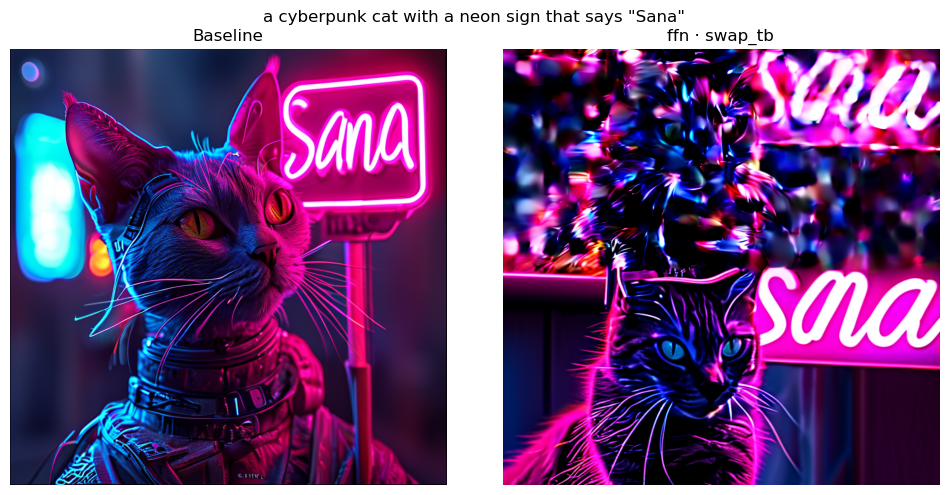

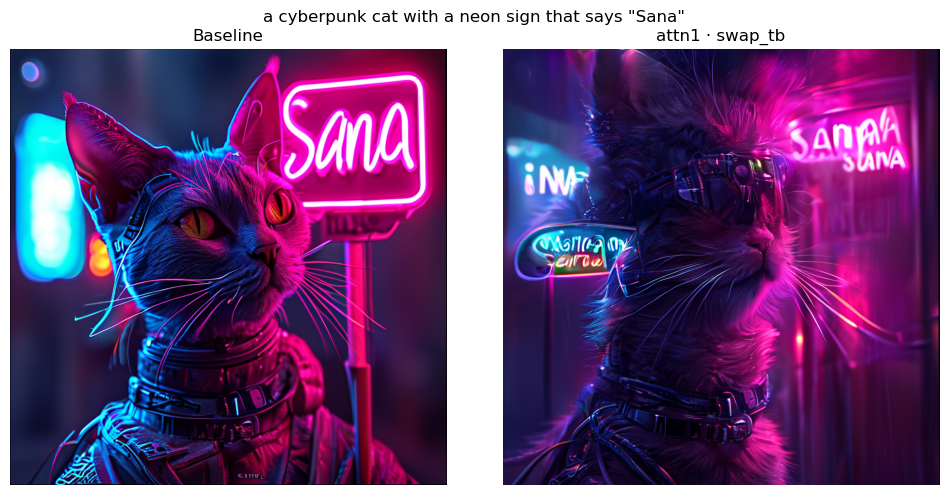

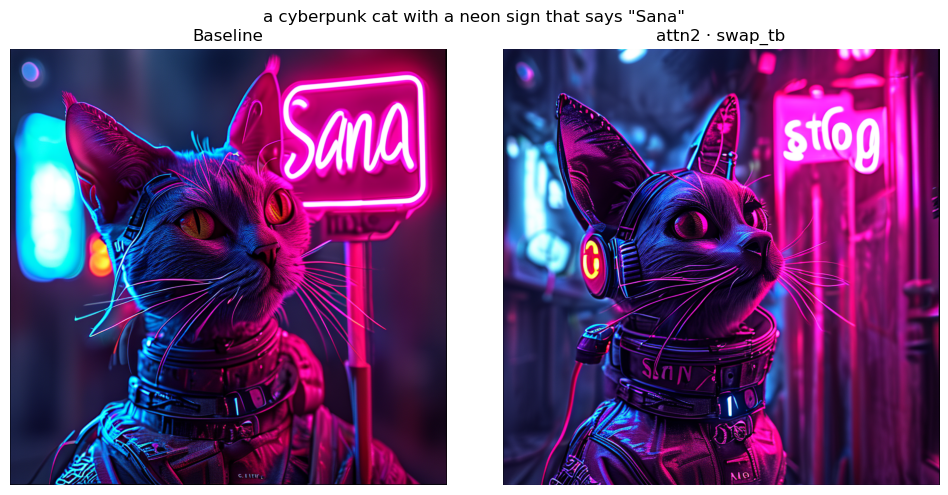

In [15]:
idx = 2
show_pair(idx, "ffn", transform=transform_choice)
show_pair(idx, "attn1", transform=transform_choice)
show_pair(idx, "attn2", transform=transform_choice)


transform_choice = "first_token" | "first_n_tokens" | "first_row" | "first_col" |
                   "swap_lr" | "swap_tb" | "swap_quadrants" | "shuffle"
